# ***Import Libraries***

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import keras
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# ***Reading Data***

In [3]:
# Sort the image and mask filenames to ensure they match
image_files = sorted(os.listdir('SegmentationDataset/images'))
mask_files = sorted(os.listdir('SegmentationDataset/masks'))

print(image_files[:6])
print("=================")
print(mask_files[:6])

['1.jpg', '10.jpg', '100.jpg', '1000.jpg', '1001.jpg', '1002.jpg']
['1.jpg', '10.jpg', '100.jpg', '1000.jpg', '1001.jpg', '1002.jpg']


In [4]:
def display_images_masks(imagepath, maskpath):
        count = 0
        for image_file, mask_file in zip(image_files, mask_files):
            if count >= 4:  # Display only the first 4 images from each folder
                break
            imagepath_full = os.path.join(imagepath, image_file)
            maskpath_full = os.path.join(maskpath, mask_file)
            image = cv2.imread(imagepath_full)
            mask = cv2.imread(maskpath_full)
            if image is None:
                raise ValueError(f"Image at path {imagepath_full} could not be loaded")
            if mask is None:
                raise ValueError(f"Mask at path {maskpath_full} could not be loaded")
            plt.figure(figsize=(10, 10))
            # First subplot (image)
            plt.subplot(1, 3, 1)
            plt.imshow(image)
            plt.title('Image')
            # Second subplot (mask)
            plt.subplot(1, 3, 2)
            plt.imshow(mask)
            plt.title('Mask')
            # Third subplot (Image with Contours)
            plt.subplot(1, 3, 3)
            sample = np.array(np.squeeze(mask), dtype = np.uint8)
            contours, hier = cv2.findContours(sample[:,:,1],cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
            sample_over_gt = cv2.drawContours(image, contours, -1,[0,255,0], thickness=-1)
            plt.imshow(sample_over_gt)
            plt.title('Image with Contours')
            plt.show()
            count += 1

In [5]:
IMAGES_PATH='SegmentationDataset/images'
MASKS_PATH='SegmentationDataset/masks'
SIZE=256
CHANNEL=1
Num_Of_Classes=1

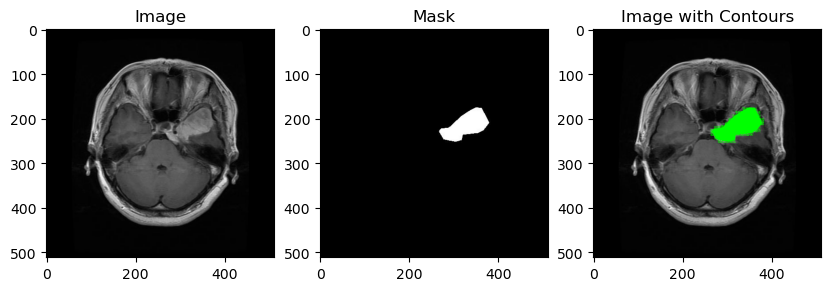

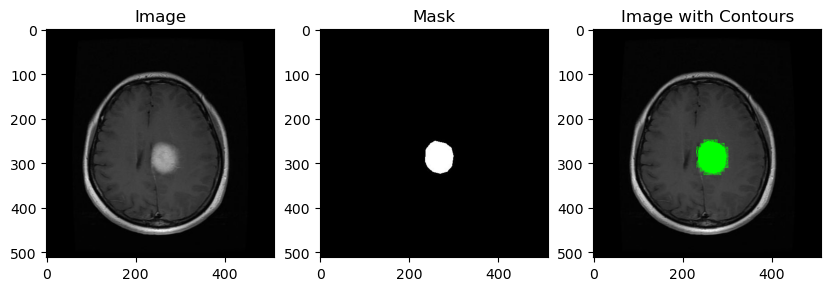

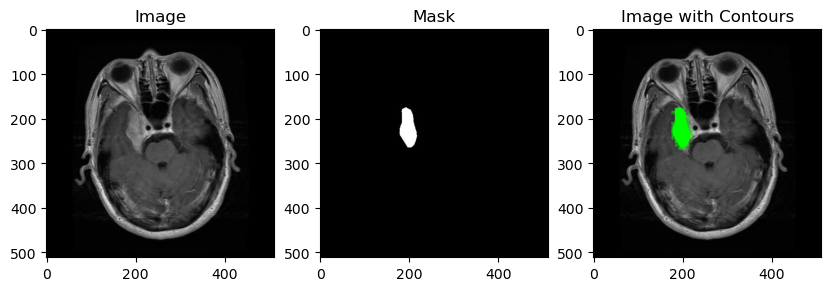

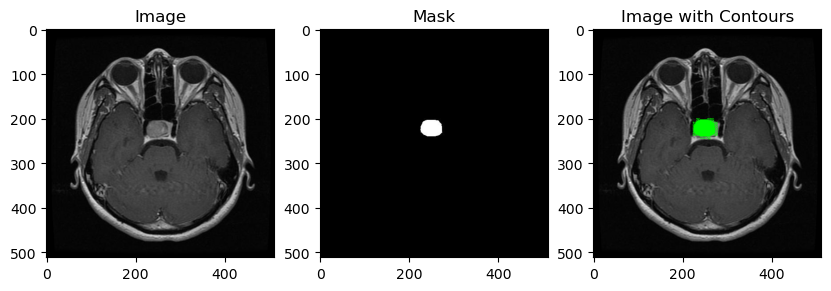

In [6]:
display_images_masks(IMAGES_PATH,MASKS_PATH)

# ***Show Different Size of Images***

In [7]:
images_size=[]
masks_size=[]
for image_file, mask_file in tqdm(zip(image_files, mask_files)):


    imagepath_full = os.path.join(IMAGES_PATH, image_file)
    maskpath_full = os.path.join(MASKS_PATH, mask_file)

    image = cv2.imread(imagepath_full)
    mask = cv2.imread(maskpath_full)

    images_size.append(image.shape)
    masks_size.append(mask.shape)

0it [00:00, ?it/s]

3064it [00:03, 841.85it/s]


In [8]:
print(list(set(images_size)))
print("=================")
print(list(set(masks_size)))

[(512, 512, 3), (256, 256, 3)]
[(512, 512, 3), (256, 256, 3)]


# ***Preprocessing Images & Masks***

In [9]:
def preprocessing_images_masks():
    images=[]
    masks=[]

    for image_file, mask_file in tqdm(zip(image_files, mask_files)):


        imagepath_full = os.path.join(IMAGES_PATH, image_file)
        maskpath_full = os.path.join(MASKS_PATH, mask_file)

        image = cv2.imread(imagepath_full,cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image,(SIZE,SIZE))
        image = image/255.0
        images.append(image)

        mask = cv2.imread(maskpath_full,cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask,(SIZE,SIZE))
        mask = mask/255.0
        masks.append(mask)

    return np.expand_dims(np.array(images), axis=-1), np.expand_dims(np.array(masks), axis=-1)

In [10]:
X,y=preprocessing_images_masks()

3064it [00:04, 666.69it/s]


In [11]:
print('The Shape of X',X.shape)
print('The Shape of y',y.shape)

The Shape of X (3064, 256, 256, 1)
The Shape of y (3064, 256, 256, 1)


# ***Split Data into Training & Testing***

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [13]:
print('The shape of X_train',X_train.shape)
print('The shape of y_train',y_train.shape)
print('The shape of X_test',X_test.shape)
print('The shape of y_test',y_test.shape)

The shape of X_train (2451, 256, 256, 1)
The shape of y_train (2451, 256, 256, 1)
The shape of X_test (613, 256, 256, 1)
The shape of y_test (613, 256, 256, 1)


# ***Defineing Loss Function and Metrics***

In [14]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# ***Build U-Net Architecture***

***Overview***

 U-Net is a convolutional neural network architecture designed for biomedical image segmentation. It was proposed by Olaf Ronneberger et al. in 2015. The architecture is particularly effective for tasks where precise localization of features is required, such as in medical imaging, but has also been successfully applied to various other segmentation tasks.

***Architecture***
* Contracting Path (Encoder): This part captures context through a series of convolutional and max-pooling layers, progressively reducing the spatial dimensions of the feature maps.
* Expanding Path (Decoder): This part enables precise localization through upsampling and concatenation of feature maps from the contracting path.

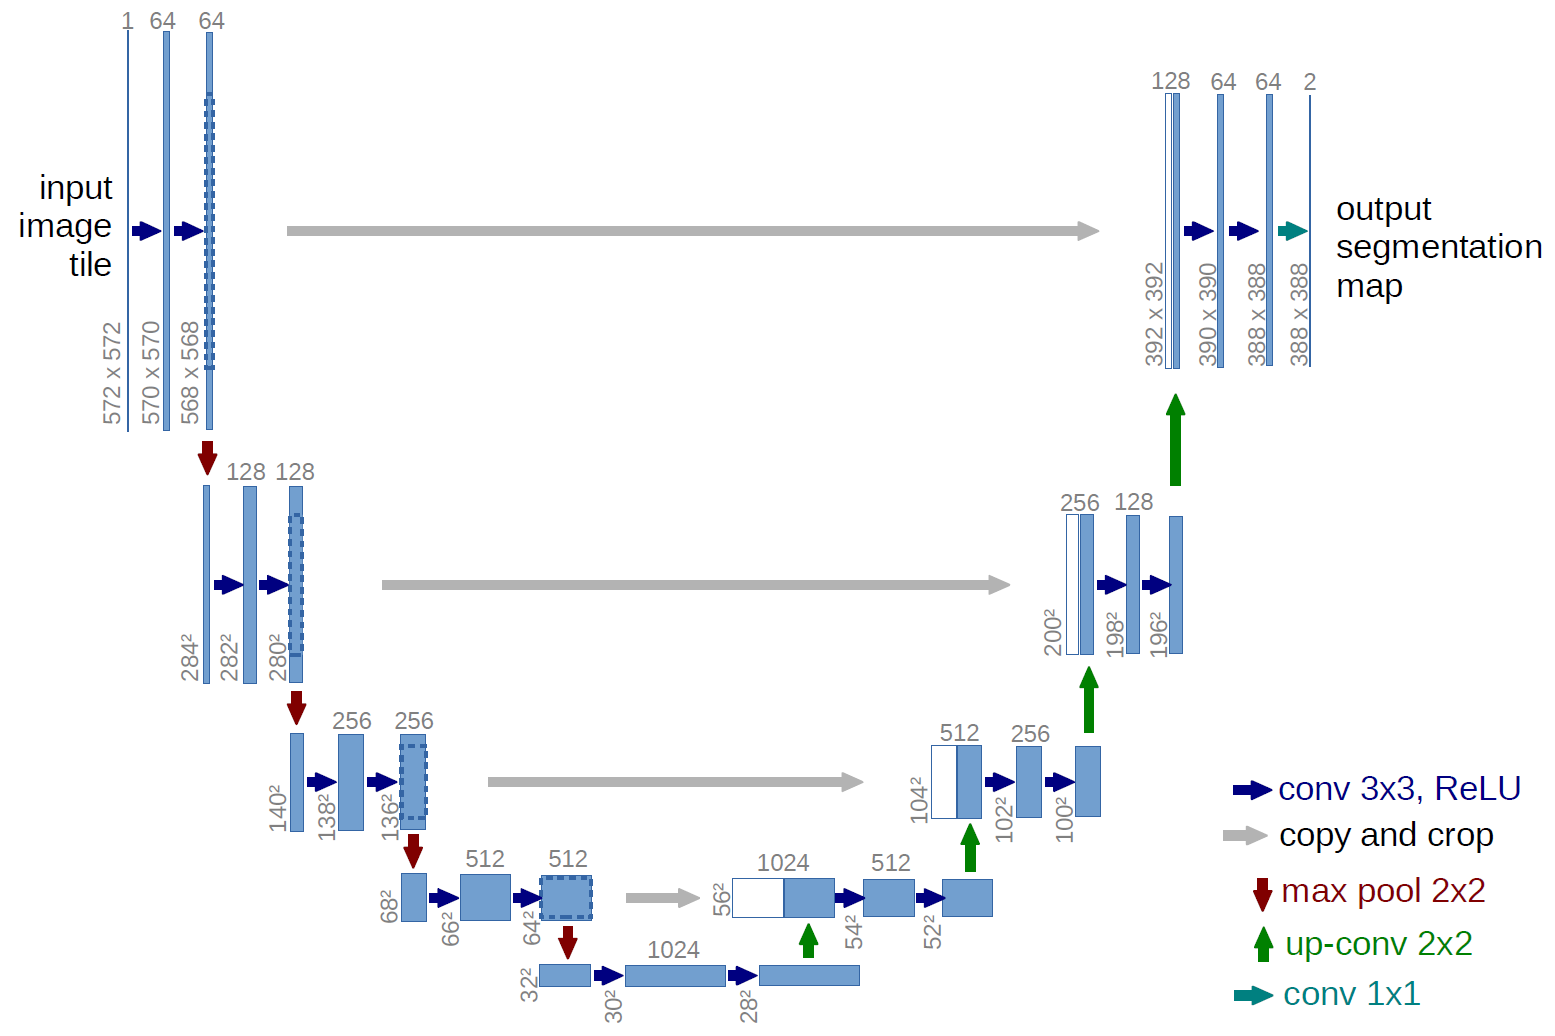

In [15]:
def unet_model(input_size=(SIZE, SIZE, CHANNEL), num_classes=Num_Of_Classes):
    inputs = keras.layers.Input(input_size)

    # Encoding (Downsampling)
    c1 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = keras.layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = keras.layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = keras.layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Decoding (Upsampling)
    u6 = keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = keras.layers.concatenate([u6, c4])
    c6 = keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = keras.layers.concatenate([u7, c3])
    c7 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = keras.layers.concatenate([u8, c2])
    c8 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = keras.layers.concatenate([u9, c1], axis=3)
    c9 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # Output layer
    outputs = keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(c9)

    model = keras.models.Model(inputs=[inputs], outputs=[outputs])
    
    return model


In [16]:
# Create and compile the model
model = unet_model(input_size=(SIZE, SIZE,CHANNEL), num_classes=Num_Of_Classes)

model.compile(optimizer=Adam(learning_rate=1e-5), loss=dice_loss, metrics=['accuracy',dice_coef])

In [17]:
# Summary of the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
earlystopping=tf.keras.callbacks.EarlyStopping(patience=20,
                                            monitor='val_accuracy',
                                            restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=0.2, 
                                                 patience=15, 
                                                 min_lr=0.0001, 
                                                 mode='min')

In [19]:
history = model.fit(X_train, y_train, batch_size=32, epochs=10,
                    validation_data=(X_test, y_test),
                    verbose=1, callbacks=[earlystopping, reduce_lr])

Epoch 1/10


In [ ]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
u_net_loss,u_net_accuracy,u_net_dice_coef=model.evaluate(X_test,y_test)
print(f'Loss is {u_net_loss}')
print(f'Accuracy is {u_net_accuracy}')
print(f'Dice_Coef is {u_net_dice_coef}')

# ***Prediction***

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(np.uint8)

In [ ]:
for i in range(10):
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(X_test[i],cmap='gray')
    
    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(y_test[i].squeeze(), cmap='gray')
    
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(y_pred[i].squeeze(), cmap='gray')
    
    plt.show()